In [70]:
import pandas as pd
import numpy as np
from pybaseball import statcast
from pybaseball import pitching_stats
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from unidecode import unidecode

In [ ]:
"""
data20_22 = statcast(start_dt = "2020-04-01", end_dt = "2022-12-01") 
data20_22.to_csv('Statcast_2020_to_2022.csv')
data23 = statcast(start_dt = "2023-04-01", end_dt = "2023-12-01")
data23.to_csv('Statcast_2023.csv')
"""

In [3]:
#Read in data
data20_22 = pd.read_csv("Statcast_2020_to_2022.csv")
data23 = statcast(start_dt = "2024-04-01", end_dt = "2024-06-09")
#data23 = pd.read_csv("Statcast_2023.csv")

This is a large query, it may take a moment to complete


  0%|          | 0/70 [00:00<?, ?it/s]/Users/maxwassarman/miniconda3/envs/baseball/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  1%|▏         | 1/70 [00:05<06:13,  5.41s/it]/Users/maxwassarman/miniconda3/envs/baseball/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  3%|▎         | 2/70 [00:06<03:09,  2.78s/it]/Users/maxwassarman/miniconda3/envs/baseball/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessin

In [76]:
data20_22['player_name'] = data20_22['player_name'].apply(unidecode)
data23['player_name'] = data23['player_name'].apply(unidecode)

In [77]:
#Select columns
data20_22 = data20_22[['player_name','pitch_type','release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','vz0','ax','ay','az','game_year','delta_run_exp']]
data23 = data23[['player_name','pitch_type','release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','vz0','ax','ay','az','game_year','delta_run_exp']]

In [78]:
#Drop na values
data20_22 = data20_22.dropna()
data23 = data23.dropna()

In [79]:
#Flip to get view from pitcher
data20_22['pfx_x'] = data20_22['pfx_x'] * -1
data23['pfx_x'] = data23['pfx_x'] * -1

#Change to inches
data20_22['pfx_x'] = data20_22['pfx_x'] * 12
data20_22['pfx_z'] = data20_22['pfx_z'] * 12
data23['pfx_x'] = data23['pfx_x'] * 12
data23['pfx_z'] = data23['pfx_z'] * 12

In [80]:
#Remove unnecessary pitches
data20_22 = data20_22[data20_22.pitch_type != 'PO']
data23 = data23[data23.pitch_type != 'PO']

In [81]:
#Retag pitches
data20_22['pitch_type'] = data20_22['pitch_type'].replace(['FF','FA'], 'Fastball')
data23['pitch_type'] = data23['pitch_type'].replace(['FF','FA'], 'Fastball')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['SI'], 'Sinker')
data23['pitch_type'] = data23['pitch_type'].replace(['SI'], 'Sinker')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['FC'], 'Cutter')
data23['pitch_type'] = data23['pitch_type'].replace(['FC'], 'Cutter')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['SL'], 'Slider')
data23['pitch_type'] = data23['pitch_type'].replace(['SL'], 'Slider')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['ST'], 'Sweeper')
data23['pitch_type'] = data23['pitch_type'].replace(['ST'], 'Sweeper')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['CU','CS','SV','KC'], 'Curveball')
data23['pitch_type'] = data23['pitch_type'].replace(['CU','CS','SV','KC'], 'Curveball')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['CH','FO','EP','KN','SC'], 'Changeup')
data23['pitch_type'] = data23['pitch_type'].replace(['CH','FO','EP','KN','SC'], 'Changeup')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['FS'], 'Splitter')
data23['pitch_type'] = data23['pitch_type'].replace(['FS'], 'Splitter')



In [82]:
#caculate vaa and haa
def approach_angles(df):
    yf = 17/12
    y0 = 50
    df['vy_f'] = -np.sqrt(df['vy0']**2 - (2 * df['ay'] * y0 - yf))
    df['t'] = (df['vy_f'] - df['vy0']) / df['ay']
    df['vz_f'] = df['vz0'] + (df['az'] * df['t'])
    df['vx_f'] = df['vx0'] + (df['ax'] * df['t'])

    df['vaa'] = -np.arctan(df['vz_f'] / df['vy_f']) * (180 / np.pi)
    df['haa'] = -np.arctan(df['vx_f'] / df['vy_f']) * (180 / np.pi)
    return df

data20_22 = approach_angles(data20_22)
data23 = approach_angles(data23)


#caculate estimated axis differential and estimated spin efficiency
def axis_differential(df):
    df['inferred_spin_degree'] = np.arctan2(df['pfx_x'],df['pfx_z']) * (180 / np.pi)
    df['axis_dif'] = np.abs(df['inferred_spin_degree'] - df['spin_axis'])
    return df

data20_22 = axis_differential(data20_22)
data23 = axis_differential(data23)


def find_most_common_fastball(df):
    fastball_types = df[df['pitch_type'].isin(['Fastball', 'Sinker', 'Cutter'])]
    most_common_fastball = fastball_types.groupby(['player_name', 'pitch_type']).size().reset_index(name='count')
    most_common_fastball = most_common_fastball.loc[most_common_fastball.groupby('player_name')['count'].idxmax()]
    most_common_fastball = most_common_fastball[['player_name', 'pitch_type']]
    most_common_fastball.rename(columns={'pitch_type': 'most_common_fastball'}, inplace=True)
    return most_common_fastball

def add_velocity_and_movement_diff(df):
    most_common_fastball = find_most_common_fastball(df)
    
    df = df.merge(most_common_fastball, on='player_name', how='left')
    
    avg_stats = df[df['pitch_type'] == df['most_common_fastball']].groupby('player_name')[['release_speed', 'pfx_x', 'pfx_z']].mean().reset_index()
    avg_stats.rename(columns={
        'release_speed': 'avg_fastball_velocity',
        'pfx_x': 'avg_fastball_pfx_x',
        'pfx_z': 'avg_fastball_pfx_z'
    }, inplace=True)
    
    df = df.merge(avg_stats, on='player_name', how='left')
    
    df['velocity_diff'] = df['avg_fastball_velocity'] - df['release_speed']
    df['horizontal_movement_diff'] = df['avg_fastball_pfx_x'] - df['pfx_x']
    df['vertical_movement_diff'] = df['avg_fastball_pfx_z'] - df['pfx_z']
    
    return df

data20_22 = add_velocity_and_movement_diff(data20_22)
data23 = add_velocity_and_movement_diff(data23)


In [83]:
#Seperate pitches for different models
fastball_20_22 = data20_22[data20_22.pitch_type.isin(['Fastball'])]
fastball_23 = data23[data23.pitch_type.isin(['Fastball'])]

sinker_20_22 = data20_22[data20_22.pitch_type.isin(['Sinker'])]
sinker_23 = data23[data23.pitch_type.isin(['Sinker'])]

cutter_20_22 = data20_22[data20_22.pitch_type.isin(['Cutter'])]
cutter_23 = data23[data23.pitch_type.isin(['Cutter'])]

slider_20_22 = data20_22[data20_22.pitch_type.isin(['Slider'])]
slider_23 = data23[data23.pitch_type.isin(['Slider'])]

sweeper_20_22 = data20_22[data20_22.pitch_type.isin(['Sweeper'])]
sweeper_23 = data23[data23.pitch_type.isin(['Sweeper'])]

curveball_20_22 = data20_22[data20_22.pitch_type.isin(['Curveball'])]
curveball_23 = data23[data23.pitch_type.isin(['Curveball'])]

changeup_20_22 = data20_22[data20_22.pitch_type.isin(['Changeup'])]
changeup_23 = data23[data23.pitch_type.isin(['Changeup'])]

splitter_20_22 = data20_22[data20_22.pitch_type.isin(['Splitter'])]
splitter_23 = data23[data23.pitch_type.isin(['Splitter'])]


In [84]:
fastball_features = ['release_speed','release_pos_x','release_pos_z','release_extension','pfx_x', 'pfx_z','game_year', 'axis_dif']
non_fastball_features = ['release_speed','release_pos_x','release_pos_z','release_extension','pfx_x', 'pfx_z','game_year', 'axis_dif', 'velocity_diff', 'horizontal_movement_diff', 'vertical_movement_diff']

In [85]:
#Split into train and test

fastball_x = fastball_20_22[fastball_features]
fastball_y = fastball_20_22['delta_run_exp']

x_train_fastball, x_test_fastball, y_train_fastball, y_test_fastball = train_test_split(fastball_x, fastball_y, train_size = 0.75, random_state = 12345)

sinker_x = sinker_20_22[non_fastball_features]
sinker_y = sinker_20_22['delta_run_exp']

x_train_sinker, x_test_sinker, y_train_sinker, y_test_sinker = train_test_split(sinker_x, sinker_y, train_size=0.75, random_state=12345)

cutter_x = cutter_20_22[non_fastball_features]
cutter_y = cutter_20_22['delta_run_exp']

x_train_cutter, x_test_cutter, y_train_cutter, y_test_cutter = train_test_split(cutter_x, cutter_y, train_size=0.75, random_state=12345)

slider_x = slider_20_22[non_fastball_features]
slider_y = slider_20_22['delta_run_exp']

x_train_slider, x_test_slider, y_train_slider, y_test_slider = train_test_split(slider_x, slider_y, train_size=0.75, random_state=12345)

sweeper_x = sweeper_20_22[non_fastball_features]
sweeper_y = sweeper_20_22['delta_run_exp']

x_train_sweeper, x_test_sweeper, y_train_sweeper, y_test_sweeper = train_test_split(sweeper_x, sweeper_y, train_size=0.75, random_state=12345)

curveball_x = curveball_20_22[non_fastball_features]
curveball_y = curveball_20_22['delta_run_exp']

x_train_curveball, x_test_curveball, y_train_curveball, y_test_curveball = train_test_split(curveball_x, curveball_y, train_size=0.75, random_state=12345)

changeup_x = changeup_20_22[non_fastball_features]
changeup_y = changeup_20_22['delta_run_exp']

x_train_changeup, x_test_changeup, y_train_changeup, y_test_changeup = train_test_split(changeup_x, changeup_y, train_size=0.75, random_state=12345)

splitter_x = splitter_20_22[non_fastball_features]
splitter_y = splitter_20_22['delta_run_exp']

x_train_splitter, x_test_splitter, y_train_splitter, y_test_splitter = train_test_split(splitter_x, splitter_y, train_size=0.75, random_state=12345)

In [86]:
#Set params for catboost models (Random ones right now)
params = {
    'iterations': 500,
    'depth': 5,
    'learning_rate': 0.11, #manual checks with FIP corr both predictive and descriptive
    'random_seed': 12345
    
}


In [87]:
#Train each model

#Fastball
fastball_model = CatBoostRegressor(**params)
fastball_model.fit(x_train_fastball, y_train_fastball)

#Sinker
sinker_model = CatBoostRegressor(**params)
sinker_model.fit(x_train_sinker, y_train_sinker)

#Cutter
cutter_model = CatBoostRegressor(**params)
cutter_model.fit(x_train_cutter, y_train_cutter)

#Slider
slider_model = CatBoostRegressor(**params)
slider_model.fit(x_train_slider, y_train_slider)

#Sweeper
sweeper_model = CatBoostRegressor(**params)
sweeper_model.fit(x_train_sweeper, y_train_sweeper)

#Curveball
curveball_model = CatBoostRegressor(**params)
curveball_model.fit(x_train_curveball, y_train_curveball)

#Changeup
changeup_model = CatBoostRegressor(**params)
changeup_model.fit(x_train_changeup, y_train_changeup)

#Splitter
splitter_model = CatBoostRegressor(**params)
splitter_model.fit(x_train_splitter, y_train_splitter)



0:	learn: 0.2404873	total: 15ms	remaining: 7.47s
1:	learn: 0.2404749	total: 25.1ms	remaining: 6.25s
2:	learn: 0.2404595	total: 35.1ms	remaining: 5.81s
3:	learn: 0.2404467	total: 46.3ms	remaining: 5.74s
4:	learn: 0.2404335	total: 56.5ms	remaining: 5.59s
5:	learn: 0.2404244	total: 66.9ms	remaining: 5.51s
6:	learn: 0.2404140	total: 76.5ms	remaining: 5.39s
7:	learn: 0.2404051	total: 87.8ms	remaining: 5.4s
8:	learn: 0.2403980	total: 99.5ms	remaining: 5.43s
9:	learn: 0.2403905	total: 112ms	remaining: 5.49s
10:	learn: 0.2403824	total: 127ms	remaining: 5.63s
11:	learn: 0.2403759	total: 139ms	remaining: 5.66s
12:	learn: 0.2403704	total: 149ms	remaining: 5.59s
13:	learn: 0.2403651	total: 160ms	remaining: 5.57s
14:	learn: 0.2403605	total: 172ms	remaining: 5.55s
15:	learn: 0.2403560	total: 182ms	remaining: 5.51s
16:	learn: 0.2403505	total: 193ms	remaining: 5.48s
17:	learn: 0.2403459	total: 205ms	remaining: 5.49s
18:	learn: 0.2403415	total: 216ms	remaining: 5.46s
19:	learn: 0.2403377	total: 227ms	r

In [90]:
#Predictions
fastball_23['pred'] = fastball_model.predict(fastball_23[fastball_features])

sinker_23['pred'] = sinker_model.predict(sinker_23[non_fastball_features])

cutter_23['pred'] = cutter_model.predict(cutter_23[non_fastball_features])

slider_23['pred'] = slider_model.predict(slider_23[non_fastball_features])

sweeper_23['pred'] = sweeper_model.predict(sweeper_23[non_fastball_features])

curveball_23['pred'] = curveball_model.predict(curveball_23[non_fastball_features])

changeup_23['pred'] = changeup_model.predict(changeup_23[non_fastball_features])

splitter_23['pred'] = splitter_model.predict(splitter_23[non_fastball_features])

/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_10052/668035254.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastball_23['pred'] = fastball_model.predict(fastball_23[fastball_features])
/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_10052/668035254.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sinker_23['pred'] = sinker_model.predict(sinker_23[non_fastball_features])
/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_10052/668035254.py:6: SettingWithCopyWarning: 


In [91]:
def scale_and_score(df):
    df['scaled'] = df['pred'] - df['pred'].max()
    df['scaled'] = abs(df['scaled'])
    df['scaled'] = df['scaled'] - df['scaled'].mean()
    df['scaled'] = df['scaled'] / df['scaled'].std()
    df['score'] = df['scaled'] * 10 + 100
    return df

In [92]:
scale_and_score(fastball_23)
scale_and_score(sinker_23)
scale_and_score(cutter_23)
scale_and_score(slider_23)
scale_and_score(sweeper_23)
scale_and_score(curveball_23)
scale_and_score(changeup_23)
scale_and_score(splitter_23)

/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_10052/625622879.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['scaled'] = df['pred'] - df['pred'].max()
/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_10052/625622879.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['scaled'] = abs(df['scaled'])
/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_10052/625622879.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

,player_name,pitch_type,release_speed,release_pos_x,release_pos_z,release_spin_rate,release_extension,spin_axis,pfx_x,pfx_z,...,most_common_fastball,avg_fastball_velocity,avg_fastball_pfx_x,avg_fastball_pfx_z,velocity_diff,horizontal_movement_diff,vertical_movement_diff,pred,scaled,score
358,"Neris, Hector",Splitter,83.0,-1.34,6.21,1061,6.2,261,-100.8,36.0,...,Fastball,92.687912,-100.578462,206.711209,9.687912,0.221538,170.711209,-0.009334,0.292077,102.920773
361,"Neris, Hector",Splitter,83.3,-1.3,6.2,1064,6.2,258,-122.4,23.04,...,Fastball,92.687912,-100.578462,206.711209,9.387912,21.821538,183.671209,-0.005508,0.216012,102.160120
367,"Neris, Hector",Splitter,82.5,-1.39,6.25,1515,6.3,250,-90.72,20.16,...,Fastball,92.687912,-100.578462,206.711209,10.187912,-9.858462,186.551209,-0.019011,0.484496,104.844958
389,"Leiter Jr., Mark",Splitter,83.3,-1.38,5.8,784,6.6,235,-142.56,77.76,...,Sinker,91.23876,-169.707907,139.780465,7.93876,-27.147907,62.020465,-0.028029,0.663801,106.638005
390,"Leiter Jr., Mark",Splitter,83.8,-1.36,5.82,781,6.8,234,-112.32,69.12,...,Sinker,91.23876,-169.707907,139.780465,7.43876,-57.387907,70.660465,-0.026519,0.633761,106.337610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267657,"Barnes, Matt",Splitter,84.8,-1.63,6.44,1377,6.9,244,-169.92,43.2,...,Fastball,91.395604,-136.467692,199.732747,6.595604,33.452308,156.532747,-0.011294,0.331057,103.310574
267658,"Barnes, Matt",Splitter,86.2,-1.5,6.39,1412,6.9,241,-174.24,53.28,...,Fastball,91.395604,-136.467692,199.732747,5.195604,37.772308,146.452747,-0.021041,0.524854,105.248543
267659,"Barnes, Matt",Splitter,84.9,-1.53,6.48,1323,6.9,241,-128.16,38.88,...,Fastball,91.395604,-136.467692,199.732747,6.495604,-8.307692,160.852747,-0.013430,0.373525,103.735245
267662,"Barnes, Matt",Splitter,85.8,-1.55,6.43,1537,6.8,237,-168.48,28.8,...,Fastball,91.395604,-136.467692,199.732747,5.595604,32.012308,170.932747,-0.023505,0.573852,105.738519


In [93]:
def calculate_mean_scores(df):
    mean_scores = df.groupby('player_name')['score'].mean().reset_index()
    mean_scores.rename(columns={'score': 'mean_scores'}, inplace=True)
    mean_scores = mean_scores.sort_values(by='mean_scores', ascending=False)
    mean_scores['mean_scores'] = mean_scores['mean_scores'].round(2)
    return mean_scores

mean_scores_fastball = calculate_mean_scores(fastball_23)
mean_scores_sinker = calculate_mean_scores(sinker_23)
mean_scores_cutter = calculate_mean_scores(cutter_23)
mean_scores_slider = calculate_mean_scores(slider_23)
mean_scores_sweeper = calculate_mean_scores(sweeper_23)
mean_scores_curveball = calculate_mean_scores(curveball_23)
mean_scores_changeup = calculate_mean_scores(changeup_23)
mean_scores_splitter = calculate_mean_scores(splitter_23)


combined_scores = mean_scores_fastball
combined_scores = combined_scores.merge(mean_scores_sinker, how = 'outer', on = 'player_name', suffixes=('','_sinker'))
combined_scores = combined_scores.merge(mean_scores_cutter, how = 'outer', on = 'player_name', suffixes=('','_cutter'))
combined_scores = combined_scores.merge(mean_scores_slider, how = 'outer', on = 'player_name', suffixes=('','_slider'))
combined_scores = combined_scores.merge(mean_scores_sweeper, how = 'outer', on = 'player_name', suffixes=('','_sweeper'))
combined_scores = combined_scores.merge(mean_scores_curveball, how = 'outer', on = 'player_name', suffixes=('','_curveball'))
combined_scores = combined_scores.merge(mean_scores_changeup, how = 'outer', on = 'player_name', suffixes=('','_changeup'))
combined_scores = combined_scores.merge(mean_scores_splitter, how = 'outer', on = 'player_name', suffixes=('','_splitter'))



combined_scores = combined_scores.rename(columns = {
    'mean_scores': 'fastball',
    'mean_scores_sinker': 'sinker',
    'mean_scores_cutter': 'cutter',
    'mean_scores_slider': 'slider',
    'mean_scores_sweeper': 'sweeper',
    'mean_scores_curveball': 'curveball',
    'mean_scores_changeup': 'changeup',
    'mean_scores_splitter': 'splitter'
    }
)

In [94]:
#my_value = 'Helsley, Ryan'
my_value = 'Suárez, Ranger'
results = combined_scores.loc[combined_scores["player_name"] == my_value]
results

,player_name,fastball,sinker,cutter,slider,sweeper,curveball,changeup,splitter


In [95]:
combined_scores

,player_name,fastball,sinker,cutter,slider,sweeper,curveball,changeup,splitter
0,"Abbott, Andrew",96.49,NaN,NaN,96.72,100.60,98.25,97.69,NaN
1,"Abreu, Bryan",104.20,NaN,NaN,102.47,NaN,NaN,99.41,NaN
2,"Adam, Jason",103.45,NaN,NaN,103.02,100.99,NaN,108.47,NaN
3,"Adams, Austin",109.21,NaN,NaN,102.24,NaN,NaN,NaN,NaN
4,"Adon, Joan",95.53,102.70,NaN,97.64,NaN,98.81,100.47,NaN
...,...,...,...,...,...,...,...,...,...
637,"Young, Alex",NaN,95.36,NaN,NaN,NaN,98.03,99.38,NaN
638,"Young, Danny",NaN,103.71,93.02,NaN,95.17,NaN,NaN,NaN
639,"Zerpa, Angel",86.28,95.26,NaN,100.64,NaN,NaN,92.49,NaN
640,"Zuniga, Guillermo",97.72,113.13,NaN,100.08,NaN,NaN,107.41,NaN


In [100]:
pitch_counts = data23.groupby(['player_name', 'pitch_type']).size().unstack(fill_value=0).reset_index()

combined_data = combined_scores.merge(pitch_counts, how='outer', on='player_name')
combined_data.fillna(0, inplace=True)

combined_data['weighted_fastball'] = combined_data['fastball'] * combined_data['Fastball']
combined_data['weighted_sinker'] = combined_data['sinker'] * combined_data['Sinker']
combined_data['weighted_cutter'] = combined_data['cutter'] * combined_data['Cutter']
combined_data['weighted_slider'] = combined_data['slider'] * combined_data['Slider']
combined_data['weighted_sweeper'] = combined_data['sweeper'] * combined_data['Sweeper']
combined_data['weighted_curveball'] = combined_data['curveball'] * combined_data['Curveball']
combined_data['weighted_changeup'] = combined_data['changeup'] * combined_data['Changeup']
combined_data['weighted_splitter'] = combined_data['splitter'] * combined_data['Splitter']

combined_data['total_weighted_score'] = (
    combined_data['weighted_fastball'] +
    combined_data['weighted_sinker'] +
    combined_data['weighted_cutter'] +
    combined_data['weighted_slider'] +
    combined_data['weighted_sweeper'] +
    combined_data['weighted_curveball'] +
    combined_data['weighted_changeup'] +
    combined_data['weighted_splitter']
)

combined_data['total_pitches'] = (
    combined_data['Fastball'] +
    combined_data['Sinker'] +
    combined_data['Cutter'] +
    combined_data['Slider'] +
    combined_data['Sweeper'] +
    combined_data['Curveball'] +
    combined_data['Changeup'] +
    combined_data['Splitter']
)

combined_data['overall'] = combined_data['total_weighted_score'] / combined_data['total_pitches']
combined_data['overall'] = combined_data['overall'].round(2)

min_pitch_count = 50
combined_data = combined_data[combined_data['total_pitches'] >= min_pitch_count]

combined_data = combined_data[['player_name', 'overall', 'fastball', 'sinker', 'cutter', 'slider', 'sweeper', 'curveball', 'changeup', 'splitter']]
combined_data = combined_data.sort_values(by='overall', ascending=False)

combined_data.to_csv("pitch_scores_testing_24.csv", index=False)
combined_data

,player_name,overall,fastball,sinker,cutter,slider,sweeper,curveball,changeup,splitter
221,"Helsley, Ryan",111.37,114.92,0.00,0.00,109.34,0.00,102.59,0.00,0.00
370,"Megill, Trevor",110.49,111.53,0.00,0.00,0.00,0.00,108.22,0.00,0.00
287,"Kimbrel, Craig",110.36,112.54,0.00,0.00,0.00,0.00,105.39,0.00,0.00
154,"Fairbanks, Pete",108.37,110.23,0.00,0.00,106.16,0.00,0.00,128.17,0.00
381,"Miller, Mason",108.20,114.87,0.00,0.00,98.82,0.00,0.00,96.87,104.28
...,...,...,...,...,...,...,...,...,...,...
478,"Rogers, Tyler",87.39,107.55,109.90,0.00,53.79,0.00,0.00,0.00,0.00
116,"Coulombe, Danny",84.85,92.62,98.16,98.04,0.00,59.76,88.46,0.00,0.00
319,"Little, Brendon",84.80,0.00,98.65,75.46,0.00,0.00,55.19,0.00,0.00
279,"Kelly, Kevin",83.13,117.84,109.10,31.86,0.00,45.31,0.00,0.00,0.00


In [20]:
combined_data.sort_values(by='changeup', ascending=False).head(30)

,player_name,overall,fastball,sinker,cutter,slider,sweeper,curveball,changeup,splitter
17,"Fairbanks, Pete",108.36,109.38,0.00,0.00,107.11,0.00,0.00,125.29,0.00
50,"Megill, Tylor",102.33,106.58,0.00,92.44,93.81,98.40,100.09,119.67,105.13
162,"Anderson, Tyler",104.25,101.80,77.60,102.09,97.70,0.00,0.00,111.86,0.00
478,"Kuhnel, Joel",96.31,92.80,116.56,0.00,95.83,0.00,0.00,111.69,0.00
119,"Anderson, Grant",102.75,103.19,107.10,0.00,97.82,0.00,0.00,111.43,0.00
343,"Wells, Tyler",99.94,96.85,0.00,101.80,99.21,0.00,95.80,110.39,0.00
24,"Verlander, Justin",105.87,108.37,0.00,0.00,103.17,0.00,100.93,110.13,0.00
421,"Stripling, Ross",100.97,94.45,104.82,0.00,101.70,0.00,95.88,109.37,0.00
164,"Burdi, Nick",105.35,101.78,96.41,0.00,111.18,0.00,0.00,108.98,0.00
176,"Jax, Griffin",101.78,101.54,104.86,0.00,0.00,101.55,88.84,108.96,0.00


In [101]:
my_value = 'Suárez, Ranger'
results = combined_data.loc[combined_data["player_name"] == my_value]
results

,player_name,overall,fastball,sinker,cutter,slider,sweeper,curveball,changeup,splitter


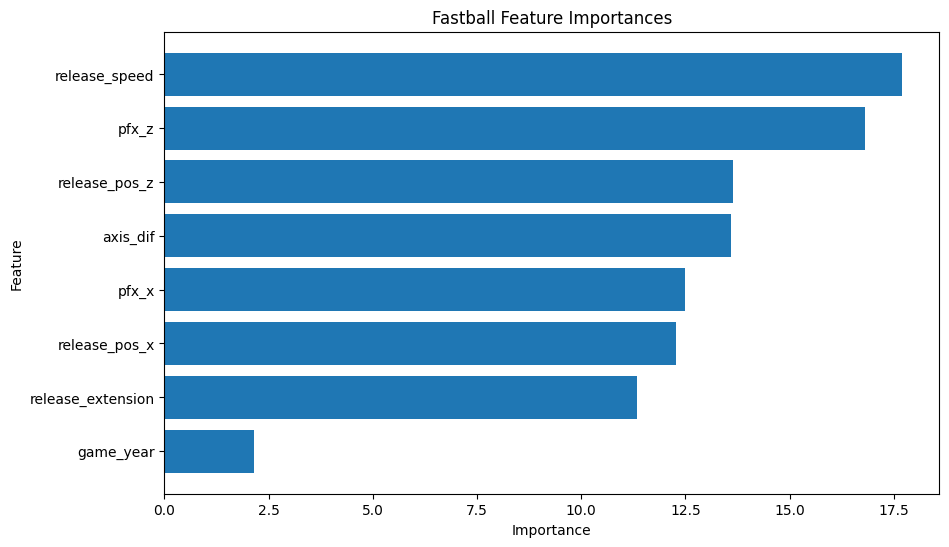

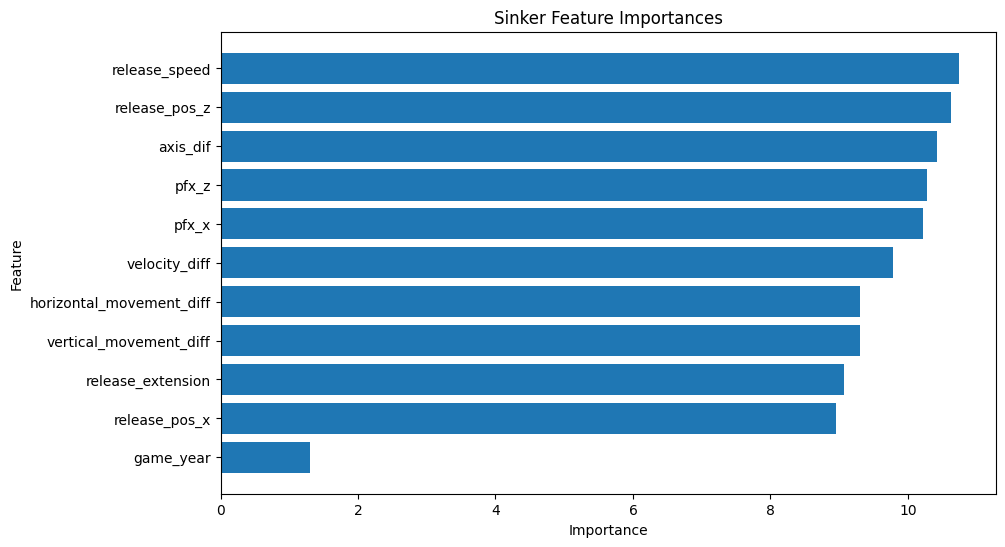

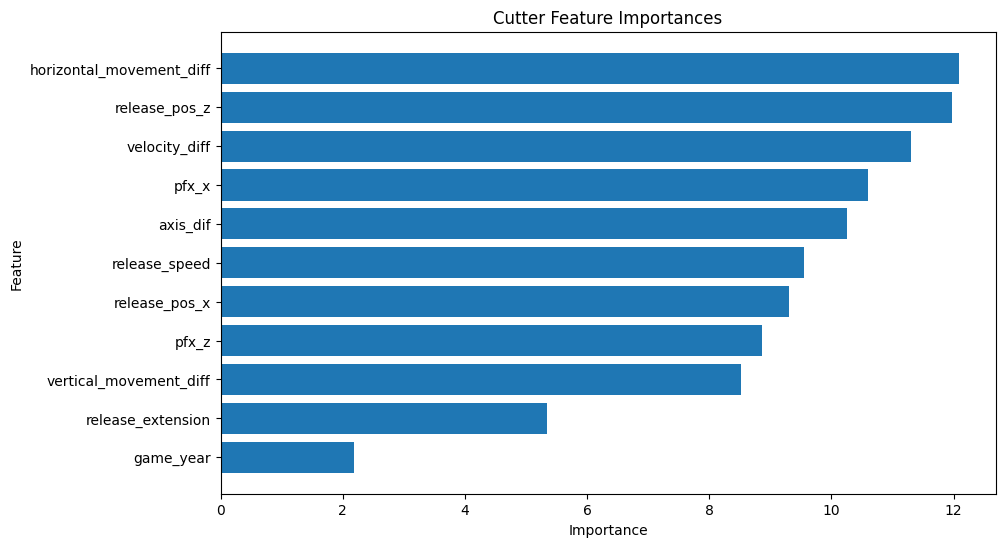

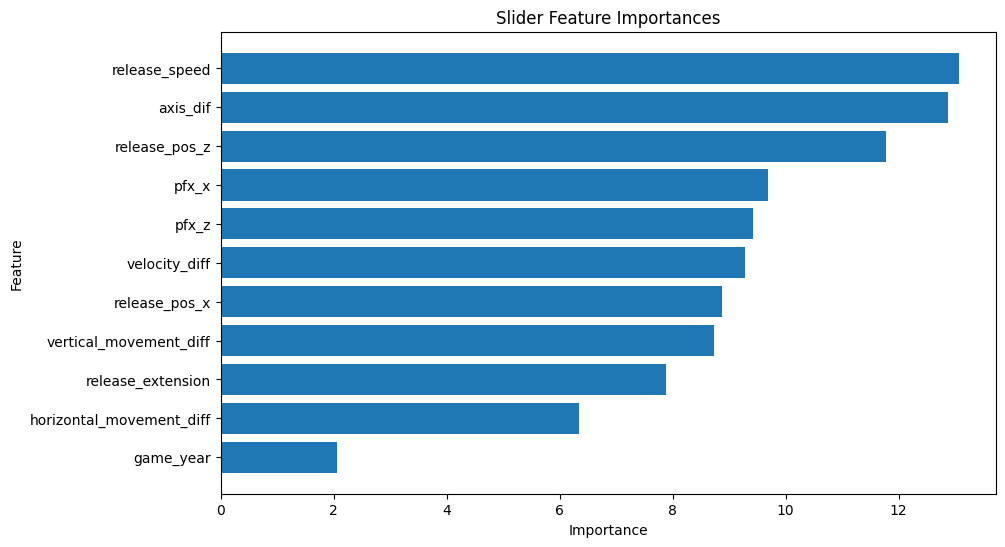

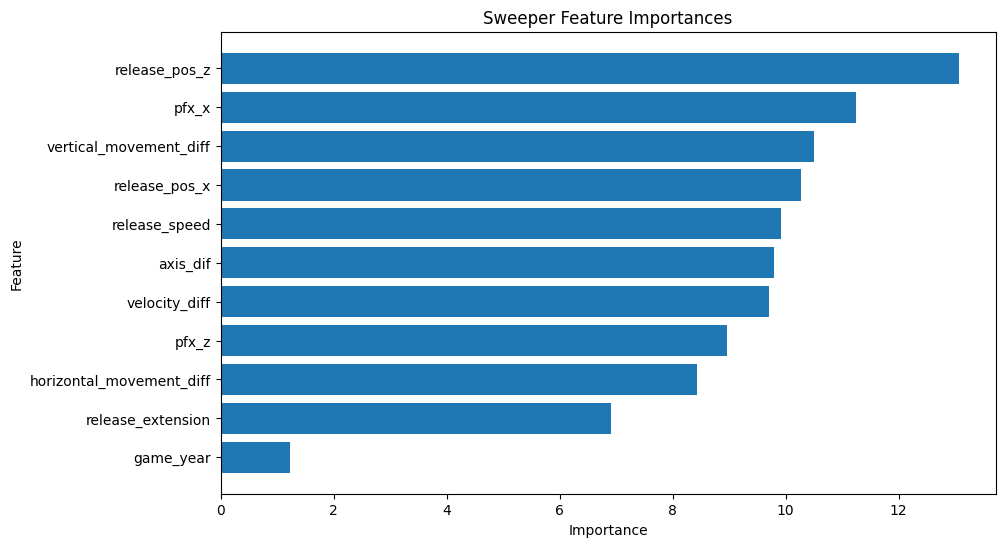

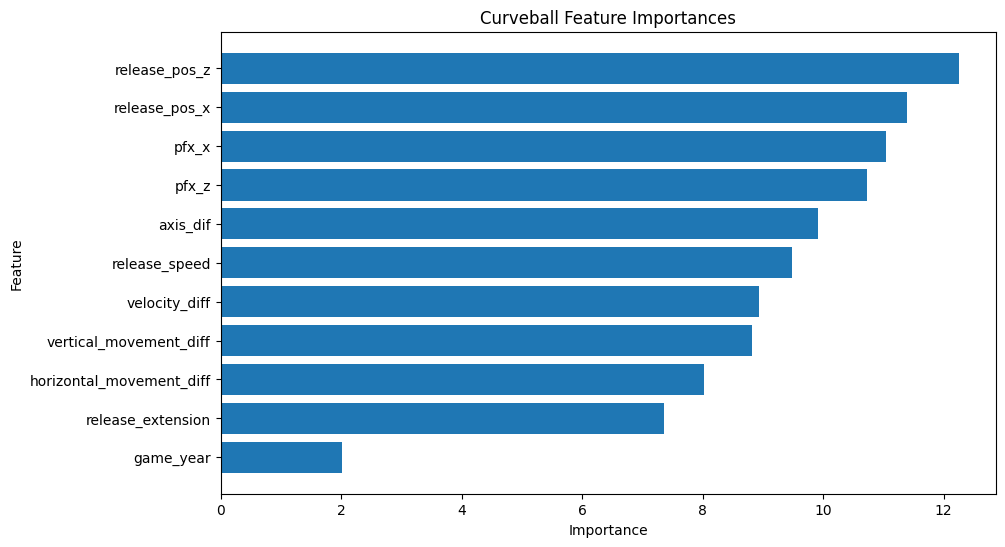

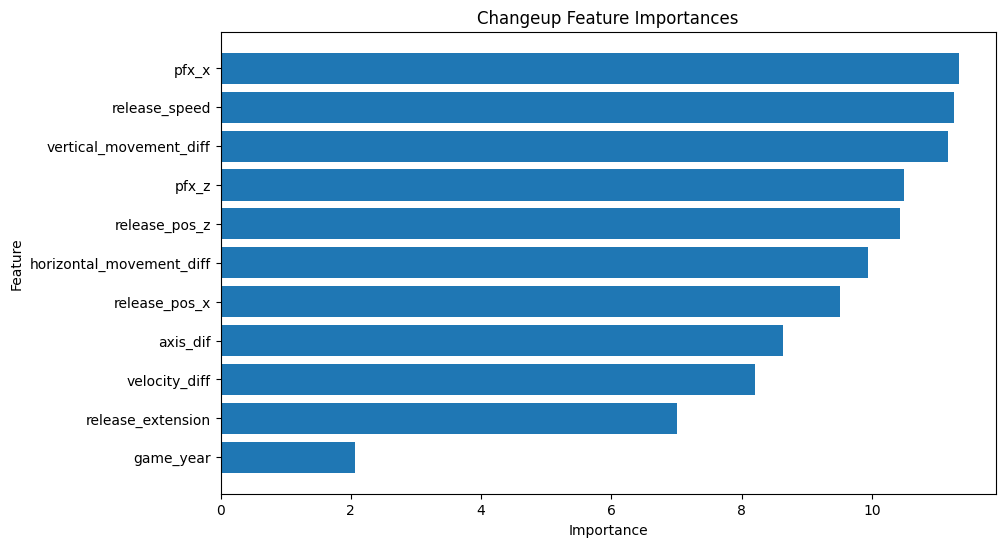

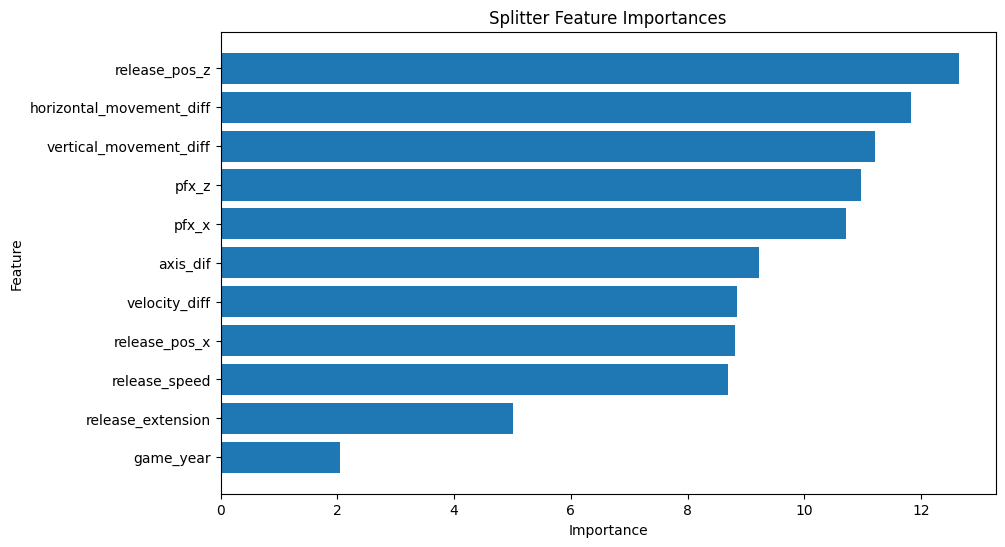

In [102]:
def plot_feature_importances(model, feature_names, title):
    feature_importances = model.get_feature_importance()
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances
    }).sort_values(by='importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()




plot_feature_importances(fastball_model, fastball_features, 'Fastball Feature Importances')
plot_feature_importances(sinker_model, non_fastball_features, 'Sinker Feature Importances')
plot_feature_importances(cutter_model, non_fastball_features, 'Cutter Feature Importances')
plot_feature_importances(slider_model, non_fastball_features, 'Slider Feature Importances')
plot_feature_importances(sweeper_model, non_fastball_features, 'Sweeper Feature Importances')
plot_feature_importances(curveball_model, non_fastball_features, 'Curveball Feature Importances')
plot_feature_importances(changeup_model, non_fastball_features, 'Changeup Feature Importances')
plot_feature_importances(splitter_model, non_fastball_features, 'Splitter Feature Importances')